$$ \LaTeX \text{ command declarations here.}
\newcommand{\R}{\mathbb{R}}
\renewcommand{\vec}[1]{\mathbf{#1}}
\newcommand{\X}{\mathcal{X}}
\newcommand{\D}{\mathcal{D}}
$$

In [1]:
from __future__ import division

# plotting
%matplotlib inline
from matplotlib import pyplot as plt;
import seaborn as sns
import pylab as pl
from matplotlib.pylab import cm
import pandas as pd


# scientific
import numpy as np;

# ipython
from IPython.display import Image

# EECS 545:  Machine Learning
## Lecture 13:  Information Theory and Exponential Families
* Instructor:  **Jacob Abernethy**
* Date:  March 7, 2016

*Lecture Exposition Credit:*  Benjamin Bray & Saket Dewaligan

## Midterm performance: Not Bad!
![](./images/midterm_histogram.png)
* Mean: 25.79, Median: 25.5, StdDev: 6.47

## Optional Final Project
* Project is **very optional**.  Students should only do project if they are serious and enthusiastic.
* Groups encouraged, up to 4 per group (effort should scale accordingly!)
* 1-page proposal due **March 23rd**, final project due **April 21**
* Projects can involve (a) new algorithms and experiments, (b) a new and exciting application, (c) literature survey, (d) a replication of published work.
* Do not submit projects from other courses! We can tell...

## Optional Final Project Grading Policy

* Students submitting a project are subject to alternative grading scheme.

|               | Basic Scheme  | With Project  |
| ------------- |:-------------:| -----:|
| Midterm       | 25%           | 18%   |
| Final Exam    | 25%           | 18%   |
| Project       | 0%            | 18%   |

* Project can help your grade, but it **can also hurt**!
* Students must commit to Project grading, but can withdraw up to April 11th.

## Review of Bias-Variance Tradeoff

### Bias and Variance Formulae

* Recall $y = f + \epsilon$, where $\epsilon$ is some $0$-mean noise with var. $\sigma^2$
* Alg receives dataset $S$ and outputs $\hat f$, prediction of $y$. The error is:

$$\mathbb{E}[(y - \hat{f})^2] = \underbrace{{\sigma^2}}_\text{irreducible error} + \underbrace{{\text{Var}[\hat{f}]}}_\text{Variance} + \underbrace{{\mathbb{E}[f - \mathbb{E}_S[\hat{f}]]}^2}_{\text{Bias}^2}$$

* Break error into two terms relating to $\mathbb{E}_{S}[\hat f]$ the "average" estimate over random datasets $S$.
    * Bias of an estim.: $\text{Bias}(\hat{f}) = (\mathbb{E}_S[\hat{f}] - f)$
    * Variance of estim.: $\text{Var}(\hat{f}) = \mathbb{E}[(\hat{f} - \mathbb{E}_S[\hat{f}])^2]$

### An example to explain Bias/Variance and illustrate the tradeoff 

- Consider estimating a sinusoidal function. 

(Example that follows is inspired by Yaser Abu-Mostafa's CS 156 Lecture titled "Bias-Variance Tradeoff"

In [2]:

RANGEXS = np.linspace(0., 2., 300)
TRUEYS = np.sin(np.pi * RANGEXS)

def plot_fit(x, y, p, show,color='k'):
    xfit = RANGEXS
    yfit = np.polyval(p, xfit)
    if show:
        axes = pl.gca()
        axes.set_xlim([min(RANGEXS),max(RANGEXS)])
        axes.set_ylim([-2.5,2.5])
        pl.scatter(x, y, facecolors='none', edgecolors=color)
        pl.plot(xfit, yfit,color=color)
        pl.hold('on')
        pl.xlabel('x')
        pl.ylabel('y')

In [3]:
def calc_errors(p):
    x = RANGEXS
    errs = []
    for i in x:
        errs.append(abs(np.polyval(p, i) - np.sin(np.pi * i)) ** 2)
    return errs

In [4]:
def calculate_bias_variance(poly_coeffs, input_values_x, true_values_y):
    # poly_coeffs: a list of polynomial coefficient vectors
    # input_values_x: the range of xvals we will see
    # true_values_y: the true labels/targes for y

    # First we calculate the mean polynomial, and compute the predictions for this mean poly
    mean_coeffs = np.mean(poly_coeffs, axis=0)
    mean_predicted_poly = np.poly1d(mean_coeffs)
    mean_predictions_y = np.polyval(mean_predicted_poly, input_values_x)
    
    # Then we calculate the error of this mean poly
    bias_errors_across_x = (mean_predictions_y - true_values_y) ** 2
    
    # To consider the variance errors, we need to look at every output of the coefficients
    variance_errors = []
    for coeff in poly_coeffs:
        predicted_poly = np.poly1d(coeff)
        predictions_y = np.polyval(predicted_poly, input_values_x)
        # Variance error is the average squared error between the predicted values of y
        # and the *average* predicted value of y
        variance_error = (mean_predictions_y - predictions_y)**2
        variance_errors.append(variance_error)

    variance_errors_across_x = np.mean(np.array(variance_errors),axis=0)
    
    return bias_errors_across_x, variance_errors_across_x

In [5]:
def polyfit_sin(degree=0, iterations=100, num_points=5, show=True):
    total = 0
    l = []
    coeffs = []
    errs = [0] * len(RANGEXS)
    colors=cm.rainbow(np.linspace(0,1,iterations))
    for i in range(iterations):
        np.random.seed()
        x = np.random.choice(RANGEXS,size=num_points) # Pick random points from the sinusoid
        y = np.sin(np.pi * x)
        p = np.polyfit(x, y, degree)  
        y_poly = [np.polyval(p, x_i) for x_i in x]  
        plot_fit(x, y, p, show,color=colors[i])
        total += sum(abs(y_poly - y) ** 2) # calculate Squared Error (Squared Error) 
        coeffs.append(p)
        errs = np.add(calc_errors(p), errs)
    return total / iterations, errs / iterations, np.mean(coeffs, axis = 0), coeffs

In [6]:
def plot_bias_and_variance(biases,variances,range_xs,true_ys,mean_predicted_ys):
    pl.plot(range_xs, mean_predicted_ys, c='k')
    axes = pl.gca()
    axes.set_xlim([min(range_xs),max(range_xs)])
    axes.set_ylim([-3,3])
    pl.hold('on')
    pl.plot(range_xs, true_ys,c='b')
    pl.errorbar(range_xs, mean_predicted_ys, yerr = biases, c='y', ls="None", zorder=0,alpha=1)
    pl.errorbar(range_xs, mean_predicted_ys, yerr = variances, c='r', ls="None", zorder=0,alpha=0.1)
    pl.xlabel('x')
    pl.ylabel('y')

## Let's return to fitting polynomials

* Here we generate some samples $x,y$, with $y = \sin(2\pi x)$
* We then fit a degree-$0$ polynomial (i.e. a constant function) to the samples 

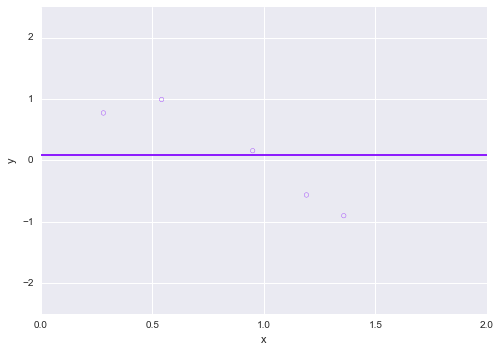

In [7]:
# polyfit_sin() generates 5 samples of the form (x,y) where y=sin(2*pi*x)
# then it tries to fit a degree=0 polynomial (i.e. a constant func.) to the data
# Ignore return values for now, we will return to these later
_, _, _, _ = polyfit_sin(degree=0, iterations=1, num_points=5, show=True)

## We can do this over many datasets

* Let's sample a number of datasets
* How does the fitted polynomial change for different datasets?

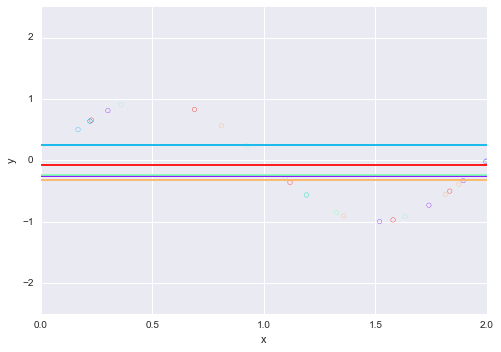

In [8]:
# Estimate two points of sin(pi * x) with a constant 5 times
_, _, _, _ = polyfit_sin(0, 5)

## What about over lots more datasets?


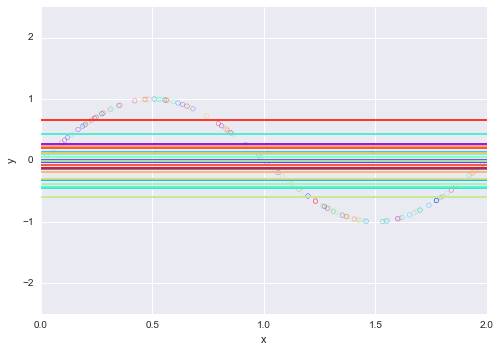

In [9]:
# Estimate two points of sin(pi * x) with a constant 100 times
_, _, _, _ = polyfit_sin(0, 25)

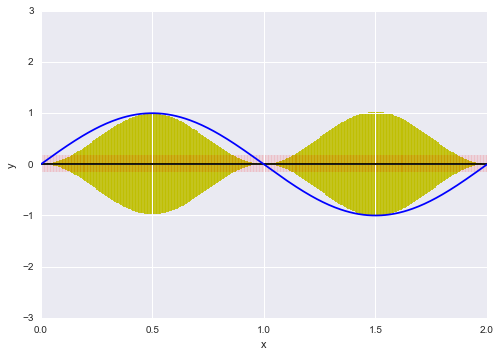

In [10]:
MSE, errs, mean_coeffs, coeffs_list = polyfit_sin(0, 100,num_points = 3,show=False)
biases, variances = calculate_bias_variance(coeffs_list,RANGEXS,TRUEYS)
plot_bias_and_variance(biases,variances,RANGEXS,TRUEYS,np.polyval(np.poly1d(mean_coeffs), RANGEXS))

* Decomposition: $\mathbb{E}[(y - \hat{f})^2] = \underbrace{{\sigma^2}}_\text{irreducible error} + \underbrace{{\text{Var}[\hat{f}]}}_\text{Variance} + \underbrace{{\mathbb{E}[f - \mathbb{E}_S[\hat{f}]]}^2}_{\text{Bias}^2}$
* Blue curve: true $f$
* Black curve: $\hat f$, average predicted values of $y$
* Yellow is error due to **Bias**, Red/Pink is error due to **Variance**

## Bias vs. Variance
* We can calculate how much error we suffered due to bias and due to variance

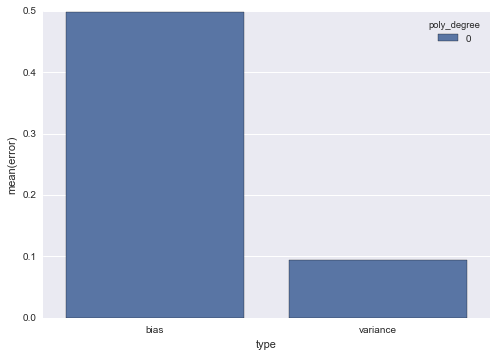

In [11]:
poly_degree = 0
results_list = []
MSE, errs, mean_coeffs, coeffs_list = polyfit_sin(
    poly_degree, 500,num_points = 5,show=False)
biases, variances = calculate_bias_variance(coeffs_list,RANGEXS,TRUEYS)
sns.barplot(x='type', y='error',hue='poly_degree', data=pd.DataFrame([
    {'error':np.mean(biases), 'type':'bias','poly_degree':0},
    {'error':np.mean(variances), 'type':'variance','poly_degree':0}]))

## Let's now fit degree=3 polynomials

* Let's sample a dataset of 5 points and fit a cubic poly

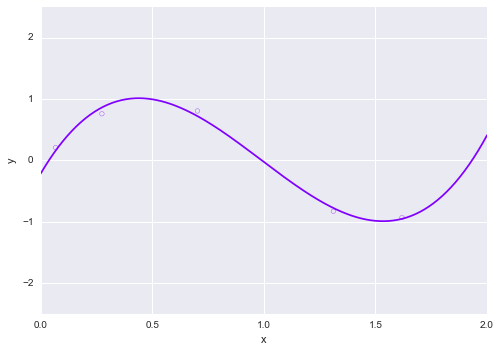

In [12]:
MSE, _, _, _ = polyfit_sin(degree=3, iterations=1)

## Let's now fit degree=3 polynomials

* What does this look like over 5 different datasets?

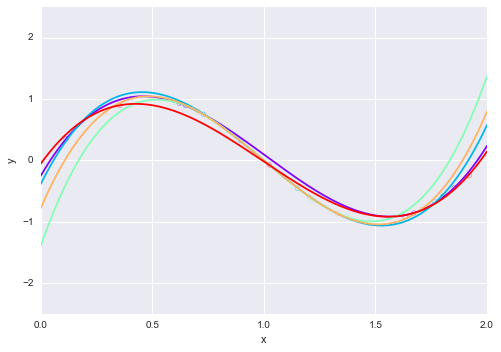

In [13]:
_, _, _, _ = polyfit_sin(degree=3,iterations=5,num_points=5,show=True)

## Let's now fit degree=3 polynomials

* What does this look like over 50 different datasets?

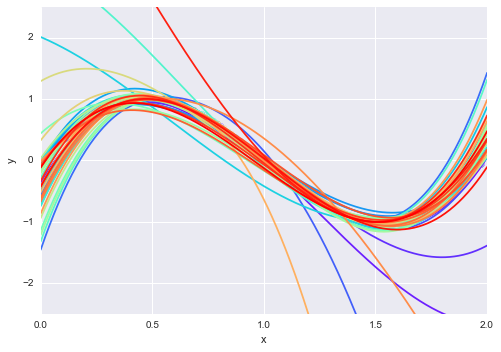

In [14]:
# Estimate two points of sin(pi * x) with a line 50 times
_, _, _, _ = polyfit_sin(degree=3, iterations=50)

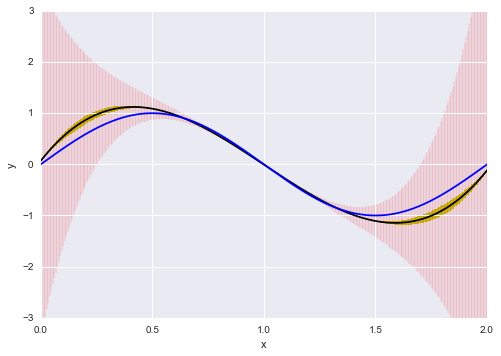

In [15]:
MSE, errs, mean_coeffs, coeffs_list = polyfit_sin(3,500,show=False)
biases, variances = calculate_bias_variance(coeffs_list,RANGEXS,TRUEYS)
plot_bias_and_variance(biases,variances,RANGEXS,TRUEYS,np.polyval(np.poly1d(mean_coeffs), RANGEXS))

$$\mathbb{E}[(y - \hat{f})^2] = \underbrace{{\sigma^2}}_\text{irreducible error} + \underbrace{{\text{Var}[\hat{f}]}}_\text{Variance} + \underbrace{{\mathbb{E}[f - \mathbb{E}_S[\hat{f}]]}^2}_{\text{Bias}^2}$$
* Blue curve: true $f$
* Black curve: $\mathbb{E}[\hat f]$, average prediction of $y$
* Yellow is error due to **Bias**, Red/Pink is error due to **Variance**

## Bias and Variance for different degree sizes

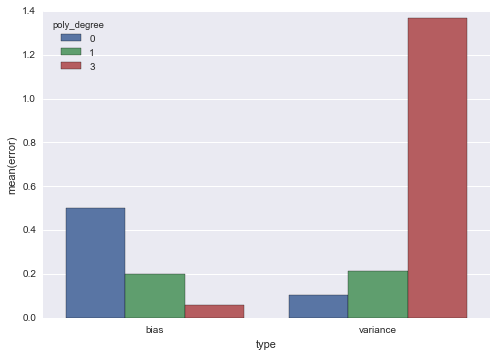

In [16]:
results_list = []
for poly_degree in [0,1,3]:
    MSE, errs, mean_coeffs, coeffs_list = polyfit_sin(poly_degree,500,num_points=5,show=False)
    biases, variances = calculate_bias_variance(coeffs_list,RANGEXS,TRUEYS)
    results_list.append({'error':np.mean(biases),
                         'type':'bias', 'poly_degree':poly_degree})
    results_list.append({'error':np.mean(variances),
                         'type':'variance', 'poly_degree':poly_degree})
sns.barplot(x='type', y='error',hue='poly_degree',data=pd.DataFrame(results_list))

* High degree polys have lower bias but much greater variance!

### Info Theory + Exponential Familes -- References

Information Theory:
- **[Shannon 1951]** Shannon, Claude E.. [*The Mathematical Theory of Communication*](http://worrydream.com/refs/Shannon%20-%20A%20Mathematical%20Theory%20of%20Communication.pdf).  1951.
- **[Pierce 1980]** Pierce, John R..  [*An Introduction to Information Theory:  Symbols, Signals, and Noise*](http://www.amazon.com/An-Introduction-Information-Theory-Mathematics/dp/0486240614).  1980.
- **[Stone 2015]** Stone, James V..  [*Information Theory:  A Tutorial Introduction*](http://jim-stone.staff.shef.ac.uk/BookInfoTheory/InfoTheoryBookMain.html).  2015.

Exponential Families:
- **[MLAPP]** Murphy, Kevin. [*Machine Learning:  A Probabilistic Perspective*](https://mitpress.mit.edu/books/machine-learning-0).  2012.
- **[Hero 2008]** Hero, Alfred O..  [*Statistical Methods for Signal Processing*](http://web.eecs.umich.edu/~hero/Preprints/main_564_08_new.pdf).  2008.
- **[Blei 2011]** Blei, David. [*Notes on Exponential Families*](https://www.cs.princeton.edu/courses/archive/fall11/cos597C/lectures/exponential-families.pdf).  2011.

## Outline

This lecture, we introduce some important background for **Probabilistic Graphical Models**.

* Information Theory
    - Information, Entropy, and Encoding
    - Relative Entropy, Mutual Information & Collocations
    - Maximum Entropy Distributions
* Exponential Family
    - Mean and Natural Parameterizations
    - Conjugate Priors & Maximum Likelihood

# Information Theory

> Uses material from **[MLAPP]** §2.8, **[Pierce 1980]**, **[Stone 2015]**, and **[Shannon 1951]**.

### Information Theory

Information theory is concerned with
- **Compression:**  Representing data in a compact fashion
- **Error Correction:**  Transmitting and storing data in a way that is robust to errors

In machine learning, information-theoretic quantities are useful for
- manipulating probability distributions
- interpreting statistical learning algorithms

### What is Information?

Can we measure the amount of **information** we gain from an observation?
- Information is measured in *bits* ( don't confuse with *binary digits*, $0110001\dots$ )
- Intuitively, observing a fair coin flip should give 1 bit of information
- Observing two fair coints should give 2 bits, and so on...

### Information:  Definition

The **information content** of an event $E$ with probability $p$ is
$$
I(E) = I(p) = - \log_2 p = \log_2 \frac{1}{p} \geq 0
$$

- Information theory is about *probabilities* and *distributions*
- The "meaning" of events doesn't matter.
- Using bases other than 2 yields different units (Hartleys, nats, ...)

### Example:  Fair Coin

**One Coin:**  If $P(Heads)=0.5$ and we observe heads, then
$$
I(Heads) = - \log_2 P(Heads) = 1 \;\mathrm{bit}
$$

**Two Coins:** If we observe two heads in a row, 
$$
\begin{align}
I(Heads,Heads)
&= -\log_2 P(Heads, Heads) \\
&= -\log_2 P(Heads)P(Heads) \\
&= -\log_2 P(Heads) - \log_2 P(Heads) = 2 \;\mathrm{bits}
\end{align}
$$

### Example:  Unfair Coin

Suppose the coin has two heads, so $P(H)=1$.  Then,
$$
I(Heads) = - \log_2 1 = 0
$$

If we know the coin is unfair, we gain no information by observing heads!
- Information is a measure of how **surprised** we are by an outcome.
- Observing heads when $P(H)=0$ yields *infinite* information.

### Entropy:  Definition

The **entropy** of a discrete random variable $X$ with distribution $p$ is
$$
H[X] = H[p] = E[I(p(X))] = - \sum_{x \in X} p(x) \log p(x)
$$

Entropy is the expected information received when we sample from $X$.
- How *surprised* are we, on average?

### Entropy:  Coin Flip

If $X$ is binary, $H[X] = -[ p \log p + (1-p) \log (1-p) ]$

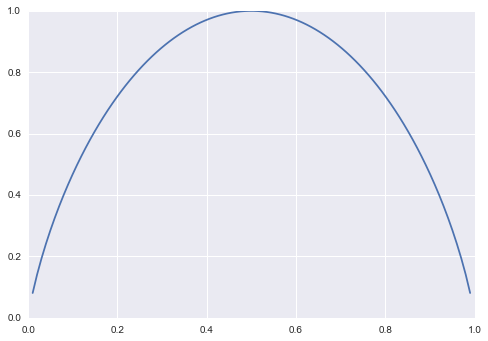

In [17]:
p = np.linspace(0.01,0.99,100);
plt.plot(p, -(p * np.log(p) + (1-p)*np.log(1-p)) / np.log(2));

### Entropy & Surprisal

Entropy is highest when $X$ is close to uniform.
- Large entropy $\iff$ high uncertainty, more information from each new observation
- Low entropy $\iff$ more knowledge about possible outcomes

The farther from uniform $X$ is, the lower the entropy.

## Break Time!

![](images/silly_cat.gif)

### Maximum Entropy Principle

Suppose we sample data from an unknown distribution $p$, and
- we collect statistics (mean, variance, etc.) from the data
- we want an *objective* or unbiased estimate of $p$

The **Maximum Entropy Principle** states that:

> We should choose $p$ to have maximum entropy $H[p]$ among all distributions satisfying our constraints.

### Maximum Entropy:  Examples

Some examples of maximum entropy distributions:

<table>
<thead><th>Constraints</th><th>Maximum Entropy Distribution</th></thead>
<tbody>
    <tr><td>Min $a$, Max $b$</td><td>Uniform $U[a,b]$</td></tr>
    <tr><td>Mean $\mu$, Support $(0,+\infty)$</td><td>Exponential $Exp(\mu)$</td></tr>
    <tr><td>Mean $\mu$, Variance $\sigma^2$</td><td>Gaussian $\mathcal{N}(\mu, \sigma^2)$</td></tr>
</tbody>
</table>

Later, **Exponential Family Distributions** will generalize this concept.

### Communication Channels

For some intuition, consider a **communication channel**:
1. The **source** generates messages.
2. An **encoder** converts the message to a **signal** for transmission.
3. Signals are transmitted along a **channel**, possibly under the influence of **noise**.
4. A **decoder** attempts to reconstruct the original message from the transmitted signal.
5. The **destination** is the intended recipient.

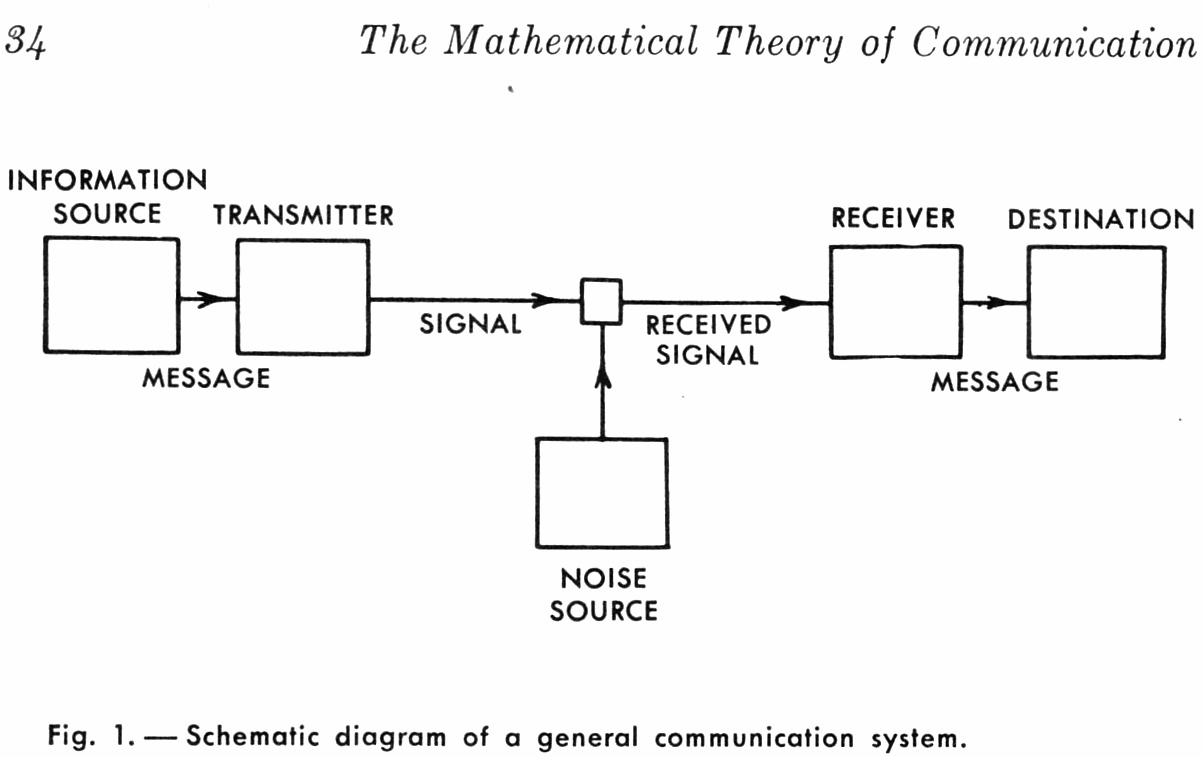

In [18]:
Image(filename="images/shannon_comm_channel.jpg")

### Encoding

Suppose we draw messages from a distribution $p$.
- Certain messages may be more likely than others.
- For example, the letter $e$ is most frequent in English

An **efficient** encoding minimizes the average message length,
- assign *short* codewords to common messages
- and *longer* codewords to rare messages

## Interesting side note on Morse Code
At the time, newspaper printers had tiny metal copies of each letter, used for printing.  A researcher apparently reasoned that they would have only as many copies of each letter as necessary to print a page, so he counted the number of copies of each letter they had and used that to estimate English letter frequencies.

[Wikipedia reference](https://en.wikipedia.org/wiki/Morse_code)

### Encoding:  Morse Code

This is precisely how **Morse Code** works!
> Approximates **Huffman Coding**, which gives optimal binary codes.

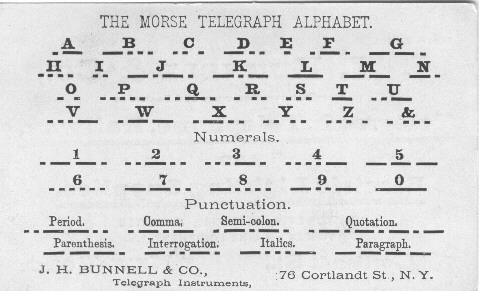

In [19]:
Image(filename="images/morse-code.jpg")

### Source Coding Theorem

Claude Shannon proved that for discrete noiseless channels:

> It is impossible to encode messages drawn from a distribution $p$ with fewer than $H[p]$ bits, on average.

Here, *bits* refers to *binary digits*, i.e. encoding messages in binary.
> $H[p]$ measures the optimal code length, in bits, for messages drawn from $p$

### Cross Entropy & Relative Entropy

Consider different distributions $p$ and $q$
- What if we use a code optimal for $q$ to encode messages from $p$?

For example, suppose our encoding scheme is optimal for German text.
- What if we send English messages instead?
- Certainly, there will be some waste due to different letter frequencies, umlauts, ...

### Cross Entropy

The **cross entropy** measures the average number of bits needed to encode messages drawn from $p$ when we use a code optimal for $q$:
$$
H(p,q) = -\sum_{x \in \X} p(x) \log q(x)
= - E_p[\log q(x)]
$$

Intuitively, $H(p,q) \geq H(p)$.  The **relative entropy** is the difference $H(p,q) - H(p)$.

### Relative Entropy:  Definition

The **relative entropy** or **Kullback-Leibler divergence** of $q$ from $p$ is

$$
\begin{align}
D_{KL}(p || q)
&= \sum_{x \in X} p(x) \log \frac{p(x)}{q(x)} \\
&= H(p,q) - H(p)
\end{align}
$$

> Measures the number of *extra* bits needed to encode messages from $p$ if we use a code optimal for $q$.

### Mutual Information:  Definition

The **mutual information** between discrete variables $X$ and $Y$ is
$$\begin{align}
I(X; Y)
&= \sum_{y\in Y} \sum_{x \in X} p(x,y) \log\frac{p(x,y)}{p(x)p(y)} \\
&= D_{KL}( p(x,y) || p(x)p(y) )
\end{align}$$

- If $X$ and $Y$ are independent, $p(x,y)=p(x)p(y)$
- So, $I(X;Y)$ measures how *independent* $X$ and $Y$ are!
- Related to correlation $\rho(X,Y)$

### Example:  Collocations & PMI

A **collocation** is a sequence of words that co-occur more often than expected by chance.
- fixed expression familiar to native speakers (hard to translate)
- meaning of the whole is more than the sum of its parts

> See [these slides](https://www.eecis.udel.edu/~trnka/CISC889-11S/lectures/philip-pmi.pdf) for more details

### Example:  Collocation & PMI

Substituting a synonym sounds unnatural:
- "fast food" vs. "quick food"
- "Great Britain" vs. "Good Britain"
- "warm greetings" vs "hot greetings"

> How can we find collocations in a corpus of text?

### Example:  Collocations & PMI

The **pointwise mutual information** between words $x$ and $y$ is
$$
\mathrm{pmi}(x;y) = \log \frac{p(x,y)}{p(x)p(y)}
$$

- $p(x)p(y)$ is how frequently we **expect** $x$ and $y$ to co-occur, if they do so independently.
- $p(x,y)$ measures how frequently $x$ and $y$ **actually** occur together

### Example:  Collocations & PMI

**Idea:**  Rank word pairs by $\mathrm{pmi}(x,y)$ to find collocations!
- $\mathrm{pmi}(x,y)$ is large if $x$ and $y$ co-occur more frequently together than expected

**Code:** Let's try it on the novel *Crime and Punishment*!
- Pre-computed unigram and bigram counts are found in the `collocations/data` folder

### Example:  Collocations & PMI

Here we read in the precomputed data.  See the notebook in the `collocations` folder for a full implementation.

In [20]:
import csv, math;

# file paths
unigram_path = "collocations/data/crime-and-punishment.txt.unigrams";
bigram_path = "collocations/data/crime-and-punishment.txt.bigrams";

# read unigrams into dict
with open(unigram_path) as f:
    reader = csv.reader(f);
    unigrams = { row[0] : int(row[1]) for row in csv.reader(f)};
    
# read bigrams into dict
with open(bigram_path) as f:
    reader = csv.reader(f);
    bigrams = { (row[0],row[1]) : int(row[2]) for row in csv.reader(f)};

# pretty print table
class PrettyTable(object):
        def __init__(self, data, head1, head2, floats=False):
            table = "<table>"
            table += "<thead><th>%s</th><th>%s</th></thead>\n" % (head1,head2);
            table += "<tbody>\n"
            for bigram,count in data:
                if floats: count = "%0.2f" % count;
                else: count = "%d" % count;

                table += "<tr>"
                table += "<td>%s %s</td>" % bigram;
                table += "<td>%s</td>" % count;
                table += "</tr>\n";

            table += "</tbody></table>"
            self.table = table;
        
        def _repr_html_(self):
            return self.table;

### Example:  Collocations & PMI

The following code sorts bigrams by pointwise mutual information:

In [21]:
# compute pmi
pmi_bigrams = [];

for w1,w2 in bigrams:
    # compute pmi
    actual = bigrams[(w1,w2)];
    expected = unigrams[w1] * unigrams[w2];
    pmi = math.log( actual / expected );
    # filter out infrequent bigrams
    if actual < 15: continue;
    pmi_bigrams.append( ((w1, w2), pmi) );

# sort pmi
pmi_sorted = sorted(pmi_bigrams, key=lambda x: x[1], reverse=True);

### Example:  Collocations & PMI

Here are the most frequent bigrams--these aren't collocations!

In [22]:
bigrams_sorted = sorted(bigrams.items(), key=lambda x: x[1], reverse=True);
PrettyTable(bigrams_sorted[:10], "Bigram", "Count")

in the,778
of the,598
he was,505
he had,498
to the,488
on the,479
i am,460
at the,459
it was,413
that he,335


### Example:  Collocations & PMI

Sorting bigrams by PMI, we first get names...

In [23]:
PrettyTable(pmi_sorted[1:10], "Collocation", "PMI", floats=True)

andrey semyonovitch,-3.18
nikodim fomitch,-3.18
hay market,-3.48
dmitri prokofitch,-3.87
honoured sir,-4.27
sofya semyonovna,-4.33
marfa petrovna,-4.37
police station,-4.48
rodion romanovitch,-4.57


### Example:  Collocations & PMI

...then more interesting collocations!  This is much more useful than sorting by frequency alone.

In [24]:
PrettyTable(pmi_sorted[12:20], "Collocation", "PMI", floats=True)

thank god,-5.20
police office,-5.23
great deal,-5.28
ten minutes,-5.40
good heavens,-5.51
thousand roubles,-5.54
katerina ivanovnas,-5.57
old womans,-5.57


### Example:  Feature Selection

Mutual information can also be used for **feature selection**.
- In classification, features that *depend* most on the class label $C$ are useful
- So, choose features $X_k$ such that $I(X_k ; C)$ is large
- This helps to avoid *overfitting* by ignoring irrelevant features!

> See **[MLAPP]** §3.5.4 for more information

# Exponential Families

> Uses material from **[MLAPP]** §9.2 and **[Hero 2008]** §3.5, §4.4.2

### Exponential Family: Introduction

We have seen many distributions.
* Bernoulli
* Gaussian
* Exponential
* Gamma 
    
Many of these belong to a more general class called the **exponential family**.

### Exponential Family:  Introduction

Why do we care?
* only family of distributions with finite-dimensional **sufficient statistics**
* only family of distributions for which **conjugate priors** exist
* makes the least set of assumptions subject to some user-chosen constraints (**Maximum Entropy**)
* core of generalized linear models and **variational inference**

### Sufficient Statistics

**Recall:** A **statistic** $T(\D)$ is a function of the observed data $\D$.
- Mean, $T(x_1, \dots, x_n) = \frac{1}{n}\sum_{k=1}^n x_k$
- Variance, maximum, mode, etc.

### Sufficient Statistics:  Definition

Suppose we have a model $P$ with parameters $\theta$.  Then,

> A statistic $T(\D)$ is **sufficient** for $\theta$ if no other statistic calculated from the same sample provides any additional information about the parameter.

That is, if $T(\D_1) = T(\D_2)$, our estimate of $\theta$ given $\D_1$ or $\D_2$ will be the same.
- Mathematically, $P(\theta | T(\D), \D) = P(\theta | T(\D))$ independently of $\D$

### Sufficient Statistics:  Example

Suppose $X \sim \mathcal{N}(\mu, \sigma^2)$ and we observe $\mathcal{D} = (x_1, \dots, x_n)$.  Let
- $\hat\mu$ be the sample mean
- $\hat{\sigma}^2$ be the sample variance

Then $T(\mathcal{D}) = (\hat\mu, \hat{\sigma}^2)$ is sufficient for $\theta=(\mu, \sigma^2)$.
- Two samples $\D_1$ and $\D_2$ with the same mean and variance give the same estimate of $\theta$

<span style="color:gray">(we are sweeping some details under the rug)</span>

### Exponential Family:  Definition

$p(x | \theta)$ has **exponential family form** if:
$$
\begin{align}
p(x | \theta)
&= \frac{1}{Z(\theta)} h(x) \exp\left[ \eta(\theta)^T \phi(x) \right] \\
&= h(x) \exp\left[ \eta(\theta)^T \phi(x) - A(\theta) \right]
\end{align}
$$

- $Z(\theta)$ is the **partition function** for normalization
- $A(\theta) = \log Z(\theta)$ is the **log partition function**
- $\phi(x) \in \R^d$ is a vector of **sufficient statistics**
- $\eta(\theta)$ maps $\theta$ to a set of **natural parameters**
- $h(x)$ is a scaling constant, usually $h(x)=1$

### Example:  Bernoulli

The Bernoulli distribution can be written as
$$
\begin{align}
\mathrm{Ber}(x | \mu)
&= \mu^x (1-\mu)^{1-x} \\
&= \exp\left[ x \log \mu + (1-x) \log (1-\mu) \right] \\
&= \exp\left[ \eta(\mu)^T \phi(x) \right]
\end{align}
$$

where $\eta(\mu) = (\log\mu, \log(1-\mu))$ and $\phi(x) = (x, 1-x)$
- There is a linear dependence between features $\phi(x)$
- This representation is **overcomplete**
- $\eta$ is not uniquely determined

### Example:  Bernoulli

Instead, we can find a **minimal** parameterization:
$$
\begin{align}
\mathrm{Ber}(x | \mu) 
&= (1-\mu) \exp\left[ x \log\frac{\mu}{1-\mu} \right]
\end{align}
$$

This gives **natural parameters** $\eta = \log \frac{\mu}{1-\mu}$.
- Now, $\eta$ is unique

### Other Examples

Exponential Family Distributions:
- Multivariate normal
- Exponential
- Dirichlet

Non-examples:
- Student t-distribution can't be written in exponential form
- Uniform distribution support depends on the parameters $\theta$

### Log-Partition Function

Derivatives of the **log-partition function** $A(\theta)$ yield **cumulants** of the sufficient statistics *(Exercise!)*
- $\nabla_\theta \log p(x|\theta) = E[\phi(x)]$
- $\nabla^2_\theta \log p(x|\theta) = Cov[ \phi(x) ]$

This guarantees that $A(\theta)$ is convex!
- Its Hessian is the covariance matrix of $X$, which is positive-definite.
- Later, this will guarantee a unique global maximum of the likelihood! 

#### <span style="color:gray">Proof of Convexity: First Derivative</span>

$$
\begin{align}
\frac{dA}{d\theta}
&= \frac{d}{d\theta} \left[ \log \int exp(\theta\phi(x))h(x)dx \right] \\
&= \frac{\frac{d}{d\theta} \int exp(\theta\phi(x))h(x)dx)}{\int exp(\theta\phi(x))h(x)dx)} \\
&= \frac{\int \phi(x)exp(\theta\phi(x))h(x)dx}{exp(A(\theta)} \\
&= \int \phi(x) \exp[\theta\phi(x)-A(\theta)] h(x) dx \\
&= \int \phi(x) p(x) dx \\
&= E[\phi(x)]
\end{align}
$$

#### <span style="color:gray">Proof of Convexity: Second Derivative</span>

$$
\begin{align}
\frac{d^2A}{d\theta^2}
& = \int \phi(x)\exp[\theta \phi(x) - A(\theta)] h(x) (\phi(x) - A'(\theta)) dx \\
& = \int \phi(x) p(x) (\phi(x) - A'(\theta))dx \\
& = \int \phi^2(x) p(X) dx - A'(\theta) \int \phi(x)p(x)dx \\
& = E[\phi^2(x)] - E[\phi(x)]^2  \hspace{2em}   (\because A'(\theta) = E[\phi(x)])  \\ 
& = Var[\phi(x)]
\end{align}
$$

#### <span style="color:gray">Proof of Convexity: Second Derivative</span>

For multi-variate case, we have 

$$ \frac{\partial^2A}{\partial\theta_i \partial\theta_j} = E[\phi_i(x)\phi_j(x)] - E[\phi_i(x)] E[\phi_j(x)]$$

and hence,
$$ \nabla^2A(\theta) = Cov[\phi(x)] $$

Since covariance is positive definite, we have $A(\theta)$ convex as required.

### Exponential Family:  Likelihood

For data $\D = (x_1, \dots, x_N)$, the likelihood is
$$
p(\D|\theta)
= \left[ \prod_{k=1}^N h(x_k) \right] Z(\theta)^{-N} \exp\left[ \eta(\theta)^T \sum_{k=1}^N \phi(x_k) \right]
$$

The sufficient statistics are now $N$ and $\phi(\D) = \sum_{k=1}^N \phi(x)$.
- **Bernoulli:** $N$ and $\phi = \# Heads$
- **Normal:** $N$ and $\phi = [ \sum_k x_k, \sum_k x_k^2 ]$

### Pitman-Koopman-Darmois Theorem

> Among families of distributions $P(x | \theta)$ whose support does not vary with the parameter $\theta$, only in exponential families is there a sufficient statistic $T(x_1,\dots,x_N)$ whose dimension remains bounded as the sample size $N$ increases.

### Exponential Family:  MLE

For natural parameters $\theta$ and data $\D = (x_1, \dots, x_N)$, 
$$
\log p(\D|\theta) = \eta^T \phi(\D) - N A(\theta)
$$

Since $-A(\theta)$ is concave and $\theta^T\phi(\D)$ linear,
- the log-likelihood is concave
- there is a unique global maximum!

### Exponential Family:  MLE

To find the maximum, recall $\nabla_\theta \log p(x|\theta) = E[\phi(x)]$, so
$$
\begin{gather}
\nabla_\theta \log p(\D | \theta) = \phi(\D) - N E[\phi(X)] = 0 \\
\implies E[\phi(X)] = \frac{\phi(\D)}{N} = \frac{1}{N} \sum_{k=1}^N \phi(x_k)
\end{gather}
$$

At the MLE $\hat\theta_{MLE}$, the empirical average of sufficient statistics equals their expected value.
- this is called **moment matching**

### Exponential Family:  MLE

As an example, consider the Bernoulli distribution
- Sufficient statistic $N$, $\phi(\D) = \# Heads$

$$
\hat\mu_{MLE} = \frac{\# Heads}{N}
$$

### Bayes for Exponential Family

Exact Bayesian analysis is considerably simplified if the prior is **conjugate** to the likelihood.
- Simply, this means that prior $p(\mathcal{D}|\tau)$ has the same form as likelihood $p(\mathcal{D}|\theta)$.

This requires likelihood to have finite sufficient statistics
* Exponential family to the rescue!

### Likelihood

Likelihood: 
$$ p(\mathcal{D}|\theta) \propto g(\theta)^N \exp[\eta(\theta)^T s_N]\\
s_N = \sum_{i=1}^{N}s(x_i)$$

In terms of canonical parameters:
$$ p(\mathcal{D}|\eta) \propto \exp[N\eta^T \bar{s} -N A(\eta)] \\
\bar s = \frac{1}{N}s_N $$

### Prior

$$ p(\theta| \nu_0, \tau_0) \propto g(\theta)^{\nu_0} \exp[\eta(\theta)^T \tau_0] $$

* Denote $ \tau_0 = \nu_0 \bar{\tau}_0$ to separate out the size of the **prior pseudo-data**, $\nu_0$ , from the mean of the sufficient statistics on this pseudo-data, $\tau_0$ . Hence,

$$ p(\theta| \nu_0, \bar \tau_0) \propto \exp[\nu_0\eta^T \bar \tau_0  - \nu_0 A(\eta)] $$

### Prior:  Example

$$
\begin{align}
p(\theta| \nu_0, \tau_0) 
&\propto (1-\theta)^{\nu_0} \exp[\tau_0\log(\frac{\theta}{1-\theta})] \\
&= \theta^{\tau_0}(1-\theta)^{\nu_0 - \tau_0}
\end{align}
$$

Define $\alpha = \tau_0 +1 $ and $\beta = \nu_0 - \tau_0 +1$ to see that this is a **beta distribution**.

### Posterior

Posterior: 
$$ p(\theta|\mathcal{D}) = p(\theta|\nu_N, \tau_N) = p(\theta| \nu_0 +N, \tau_0 +s_N) $$

Note that we obtain **hyper-parameters** by adding. Hence,

$$ \begin{align}
p(\eta|\mathcal{D})
&\propto \exp[\eta^T (\nu_0 \bar\tau_0 + N \bar s) - (\nu_0 + N) A(\eta) ] \\
&= p(\eta|\nu_0 + N, \frac{\nu_0 \bar\tau_0 + N \bar s}{\nu_0 + N})
\end{align}$$

* *posterior hyper-parameters are a convex combination of the prior mean hyper-parameters and the average of the sufficient statistics.*